In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#Review rows in Measurement
measurement_row = session.query(Measurement).first()
measurement_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11e68cc50>,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

In [11]:
#Review rows in Station
station_row = session.query(Station).first()
station_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11e6e3780>,
 'elevation': 3.0,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'latitude': 21.2716,
 'station': 'USC00519397'}

# Exploratory Climate Analysis

In [12]:
#Prep and create query for last year's precipitation scores
#Find the latest date
latest_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date = pd.to_datetime(latest_date, format='%Y-%m-%d', errors='ignore')

#Calculate the date 1 year ago from the last data point in the database
year_ago = latest_date-dt.timedelta(days = 365)
year_ago = year_ago.strftime('%Y-%m-%d')
print(latest_date, year_ago)

# Perform a query to retrieve the data and precipitation scores
last_twelve_mos = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > (year_ago[0])).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_twelve_mos_df = pd.DataFrame(last_twelve_mos)

# Sort the dataframe by date
last_twelve_mos_df = last_twelve_mos_df.sort_values(by=['date'],ascending=True)
last_twelve_mos_df = last_twelve_mos_df.set_index('date')
last_twelve_mos_df = last_twelve_mos_df.rename(columns={'prcp':'precipitation'})

DatetimeIndex(['2017-08-23'], dtype='datetime64[ns]', freq=None) Index(['2016-08-23'], dtype='object')


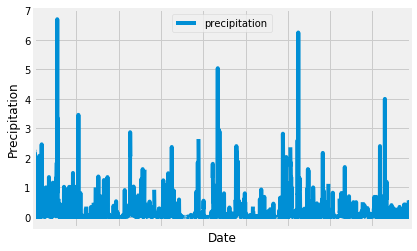

In [13]:
# Plot the data
last_twelve_mos_df.plot(y='precipitation', use_index=True)

plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.tick_params(labelbottom=False)
plt.legend(loc='upper center')

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_twelve_mos_df.describe()


,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
total_stations=session.query(func.count(distinct(Measurement.station))).scalar() 
total_stations



9

In [32]:
# What are the most active stations? (i.e. what stations have the most rows)?
station_activity = session.query(Measurement.station, func.count()).\
    group_by(Measurement.station).\
    all()
station_activity 

[('USC00511918', 1979),
 ('USC00513117', 2709),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00517948', 1372),
 ('USC00518838', 511),
 ('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00519523', 2669)]

In [67]:
# List the stations and the counts in descending order.
descending_station_activity = session.query(Measurement.station, func.count()).\
    group_by(Measurement.station).\
    order_by(func.count().desc()).\
    all()
descending_station_activity


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [98]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = descending_station_activity[0]
most_active = most_active[0]

most_active_min = session.query(Measurement.station, func.min(Measurement.tobs)).filter(Measurement.station == most_active).all()
most_active_max = session.query(Measurement.station, func.max(Measurement.tobs)).filter(Measurement.station == most_active).all()
most_active_avg = session.query(Measurement.station, func.avg(Measurement.tobs)).filter(Measurement.station == most_active).all()
print(most_active_min, most_active_max, most_active_avg)


[('USC00519281', 54.0)] [('USC00519281', 85.0)] [('USC00519281', 71.66378066378067)]


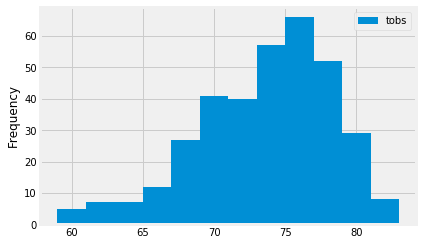

In [104]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_last_year = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date > (year_ago[0])).\
    filter(Measurement.station == most_active).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame 
most_active_last_year_df = pd.DataFrame(most_active_last_year)

# Plot the data
most_active_last_year_df.plot.hist(bins=12)



In [105]:
most_active_last_year_df.describe()

,tobs
count,351.000000
mean,73.096866
std,4.735491
min,59.000000
25%,70.000000
50%,74.000000
75%,77.000000
max,83.000000


In [106]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [152]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
previous_yr_weather = (calc_temps('2017-02-28', '2017-03-05'))
previous_yr_weather

(64.0, 72.02777777777777, 78.0)


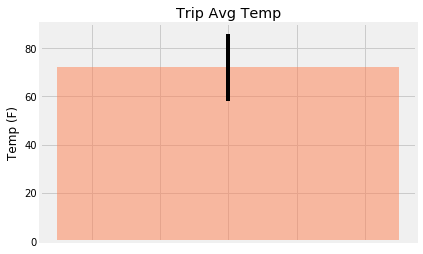

In [181]:
# Plot the results from your previous query as a bar chart. 
# previous_yr_weather_df=pd.DataFrame(previous_yr_weather, columns = ['TMIN', 'TAVE', 'TMAX'])

tmin = previous_yr_weather[0][0]
tavg = previous_yr_weather[0][1]
tmax = previous_yr_weather[0][2]
y_err = tmax-tmin

plt.bar(0, tavg, yerr=y_err, color='coral', alpha=.5, align="center")
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.tick_params(labelbottom=False)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
